# Imports

In [2]:
import os
import torch
import numpy as np
import torchvision
from PIL import Image
from pathlib import Path
from itertools import islice
import matplotlib.pyplot as plt
from torchvision.transforms import transforms
from torch.utils.data import Dataset, TensorDataset, DataLoader

np.set_printoptions(precision=3)

# Introduction to PyTorch

## Creating Tensors

In [3]:
a = [1, 2, 3]
b = np.array([4, 5, 6], dtype=np.int32)

t_a = torch.tensor(a)
t_b = torch.tensor(b)

print(t_a)
print(t_b)

tensor([1, 2, 3])
tensor([4, 5, 6], dtype=torch.int32)


In [4]:
t_ones = torch.ones(2, 3)
print(t_ones.shape)
print(t_ones)

torch.Size([2, 3])
tensor([[1., 1., 1.],
        [1., 1., 1.]])


In [5]:
rand_tensor = torch.rand(2, 3)
print(rand_tensor)

tensor([[0.7528, 0.8702, 0.6439],
        [0.2344, 0.0422, 0.4812]])


## Manipulating Data Types and Shape

In [6]:
t_a_new = t_a.to(torch.int64)
print(t_a_new.dtype)

torch.int64


### Transposing a Tensor

In [7]:
t = torch.rand(3, 5)
t_tr = torch.transpose(t, 0, 1)

print(t.shape, ' --> ', t_tr.shape)

torch.Size([3, 5])  -->  torch.Size([5, 3])


### Reshaping a Tensor

In [8]:
t = torch.zeros(30)
t_reshape = t.reshape(5, 6)
print(t.shape, ' --> ', t_reshape.shape)

torch.Size([30])  -->  torch.Size([5, 6])


### Removing Dimensions (In this case, dimensions that have a size of 1)

In [9]:
t = torch.zeros(1, 2, 1, 4, 1)
t_sqz = torch.squeeze(t, 2)

print(t.shape, ' --> ', t_sqz.shape)

torch.Size([1, 2, 1, 4, 1])  -->  torch.Size([1, 2, 4, 1])


## Applying Mathematical Operations to Tensors

In [10]:
torch.manual_seed(1)

t1 = 2 * torch.rand(5, 2) - 1 # torch.rand returns a tensor with rand nums from a uniform distribution in range of 0 to 1
t2 = torch.normal(mean=0, std=1, size=(5, 2))
t3 = torch.multiply(t1, t2)
print(t3)

tensor([[ 0.4426, -0.3114],
        [ 0.0660, -0.5970],
        [ 1.1249,  0.0150],
        [ 0.1569,  0.7107],
        [-0.0451, -0.0352]])


In [11]:
t4 = torch.mean(t1, axis=0)
print(t4)

tensor([-0.1373,  0.2028])


In [12]:
''' Matrix * Matrix Multiplication '''
t5 = torch.matmul(t1, torch.transpose(t2, 0, 1))
print(t5)

tensor([[ 0.1312,  0.3860, -0.6267, -1.0096, -0.2943],
        [ 0.1647, -0.5310,  0.2434,  0.8035,  0.1980],
        [-0.3855, -0.4422,  1.1399,  1.5558,  0.4781],
        [ 0.1822, -0.5771,  0.2585,  0.8676,  0.2132],
        [ 0.0330,  0.1084, -0.1692, -0.2771, -0.0804]])


In [13]:
t6 = torch.matmul(torch.transpose(t1, 0, 1), t2)
print(t6)

tensor([[ 1.7453,  0.3392],
        [-1.6038, -0.2180]])


In [14]:
norm_t1 = torch.linalg.norm(t1, ord=2, dim=1)
print(norm_t1)

tensor([0.6785, 0.5078, 1.1162, 0.5488, 0.1853])


In [15]:
''' verify torch.linalg.norm computes L2 Norm of t1 correctly '''
assert np.all(np.sqrt(np.sum(np.square(t1.numpy()),axis=1)) == norm_t1.numpy())

## Split, Stack, and Concatenate Tensors

In [16]:
torch.manual_seed(1)

t = torch.rand(6)

print(t)

t_splits = torch.chunk(input=t, chunks=3)
[item.numpy() for item in t_splits]

tensor([0.7576, 0.2793, 0.4031, 0.7347, 0.0293, 0.7999])


[array([0.758, 0.279], dtype=float32),
 array([0.403, 0.735], dtype=float32),
 array([0.029, 0.8  ], dtype=float32)]

In [17]:
torch.manual_seed(1)

t = torch.rand(5)
print(t)

t_splits = torch.split(t, split_size_or_sections=[3, 2])
[item.numpy() for item in t_splits]

tensor([0.7576, 0.2793, 0.4031, 0.7347, 0.0293])


[array([0.758, 0.279, 0.403], dtype=float32),
 array([0.735, 0.029], dtype=float32)]

In [18]:
A, B = torch.ones(3), torch.zeros(2)
C = torch.cat([A, B], axis=0)

print(C)

tensor([1., 1., 1., 0., 0.])


In [19]:
A, B = torch.ones(3), torch.zeros(3)
S = torch.stack([A, B], axis=1)
print(S)

tensor([[1., 0.],
        [1., 0.],
        [1., 0.]])


# Building Input Pipelines in PyTorch

## Building a PyTorch DataLoader from existing Tensors

In [20]:
t = torch.arange(6, dtype=torch.float32)
data_loader = DataLoader(dataset=t)

for item in data_loader:
    print(item)

tensor([0.])
tensor([1.])
tensor([2.])
tensor([3.])
tensor([4.])
tensor([5.])


In [21]:
data_loader = DataLoader(dataset=t, batch_size=3, drop_last=False)
for i, batch in enumerate(data_loader):
    print(f'Batch {i}: {batch}')

Batch 0: tensor([0., 1., 2.])
Batch 1: tensor([3., 4., 5.])


## Combining two tensors into a joint dataset

In [22]:
torch.manual_seed(1)

t_x = torch.rand([4, 3], dtype=torch.float32)
t_y = torch.arange(4)

class JointDataset(Dataset):
    
    def __init__(self, x : torch.tensor, y : torch.tensor) -> None :
        self.x = x
        self.y = y
        
    def __len__(self) -> int :
        return len(self.x)
    
    def __getitem__(self, index : int):
        return self.x[index], self.y[index]

joint_dataset = JointDataset(t_x, t_y)

print('Custom Dataset')
for example in joint_dataset:
    print(f' x: {example[0]} y: {example[1]}')
    
''' in this specific case, we can also use TensorDataset '''
joint_dataset = TensorDataset(t_x, t_y)

print('TensorDataset')
for example in joint_dataset:
    print(f' x: {example[0]} y: {example[1]}')

Custom Dataset
 x: tensor([0.7576, 0.2793, 0.4031]) y: 0
 x: tensor([0.7347, 0.0293, 0.7999]) y: 1
 x: tensor([0.3971, 0.7544, 0.5695]) y: 2
 x: tensor([0.4388, 0.6387, 0.5247]) y: 3
TensorDataset
 x: tensor([0.7576, 0.2793, 0.4031]) y: 0
 x: tensor([0.7347, 0.0293, 0.7999]) y: 1
 x: tensor([0.3971, 0.7544, 0.5695]) y: 2
 x: tensor([0.4388, 0.6387, 0.5247]) y: 3


## Shuffle, Batch, Repeat

In [23]:
torch.manual_seed(1)

data_loader = DataLoader(dataset=joint_dataset, batch_size=2, shuffle=True)

''' showcasing batching, shuffling, and repeat abilities of the DataLoader '''
for epoch in range(1,3):
    print(f'         Epoch {epoch}         ')
    print('-'*25)
    for i, batch in enumerate(data_loader, 1):
        print(f'Batch {i}:\n\tx: {batch[0]}\n\ty: {batch[1]}')
    print()

         Epoch 1         
-------------------------
Batch 1:
	x: tensor([[0.3971, 0.7544, 0.5695],
        [0.7576, 0.2793, 0.4031]])
	y: tensor([2, 0])
Batch 2:
	x: tensor([[0.7347, 0.0293, 0.7999],
        [0.4388, 0.6387, 0.5247]])
	y: tensor([1, 3])

         Epoch 2         
-------------------------
Batch 1:
	x: tensor([[0.7576, 0.2793, 0.4031],
        [0.3971, 0.7544, 0.5695]])
	y: tensor([0, 2])
Batch 2:
	x: tensor([[0.7347, 0.0293, 0.7999],
        [0.4388, 0.6387, 0.5247]])
	y: tensor([1, 3])



## Creating a dataset from files on your local storage

File ..\data\cat_dog_images\cat-01.jpg labeled as Cat
File ..\data\cat_dog_images\cat-02.jpg labeled as Cat
File ..\data\cat_dog_images\cat-03.jpg labeled as Cat
File ..\data\cat_dog_images\dog-01.jpg labeled as Dog
File ..\data\cat_dog_images\dog-02.jpg labeled as Dog
File ..\data\cat_dog_images\dog-03.jpg labeled as Dog

Image Shape: (900, 1200, 3)
Image Shape: (900, 1200, 3)
Image Shape: (900, 742, 3)
Image Shape: (800, 1200, 3)
Image Shape: (800, 1200, 3)
Image Shape: (900, 1200, 3)


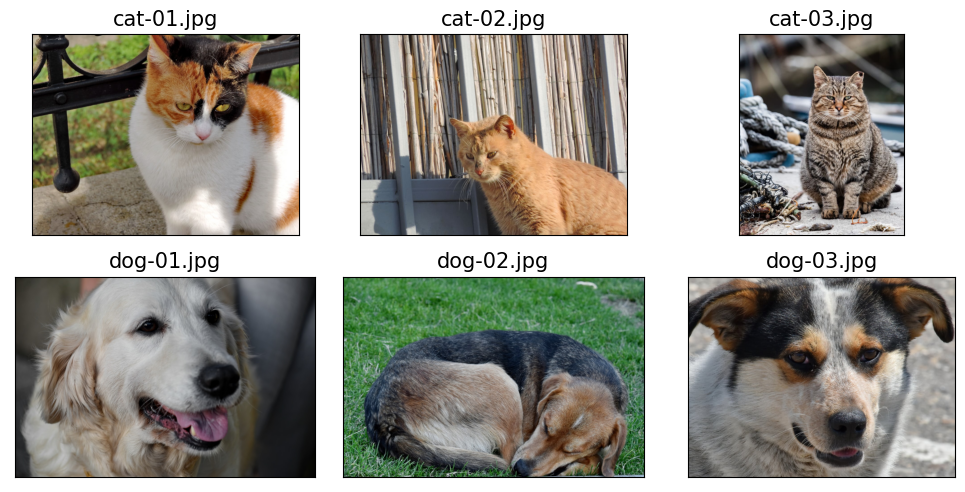

In [24]:
imgdir_path = Path('../data/cat_dog_images/')
file_list = sorted(imgdir_path.iterdir())

labels = [1 if 'dog' in os.path.basename(f) else 0 for f in file_list]

for file_name, label in zip(file_list, labels):
    print(f'File {file_name} labeled as {"Dog" if label else "Cat"}')
print()

fig = plt.figure(figsize=(10, 5))

for i, file in enumerate(file_list):
    img = Image.open(file)
    print(f'Image Shape: {np.array(img).shape}')
    
    ax = fig.add_subplot(2, 3, i + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(img)
    ax.set_title(os.path.basename(file), size=15)
    
plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


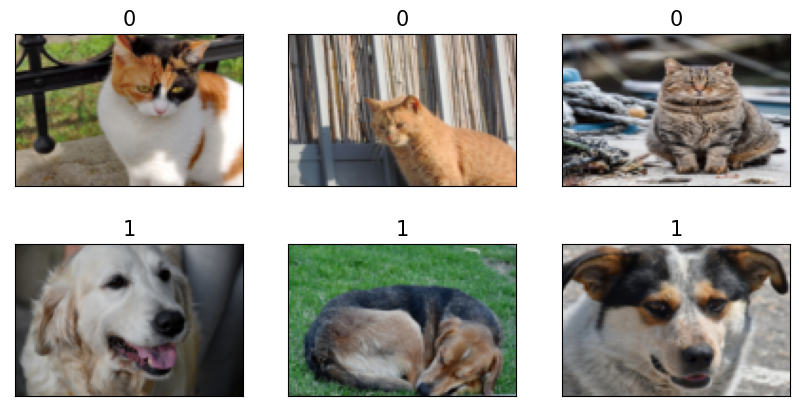

In [25]:
class ImageDataset(Dataset):
    ''' Dataset used to load images from local storage '''
    
    def __init__(
        self, 
        file_list : list, 
        labels : list, 
        transform = None
    ) -> None :
        
        self.file_list = file_list
        self.labels = labels
        self.transform = transform
        
    def __getitem__(self, index : int) -> tuple[torch.tensor, int] :
        ''' retrieves the image data stored in the file at index, as well as it's label '''
        
        img = Image.open(self.file_list[index])
        
        if self.transform is not None:
            img = self.transform(img)
        
        return img, self.labels[index]
    
    def __len__(self) -> int :
        return len(self.labels)

image_height, image_width = 80, 120

transform = transforms.Compose(
    [
        transforms.ToTensor(), # Converts PIL Image to a torch.tensor
        transforms.Resize((image_height, image_width), antialias=True) # Resizes our tensor to a standard image size
    ]
)

image_dataset = ImageDataset(file_list, labels, transform)

fig = plt.figure(figsize=(10, 5))

for i, example in enumerate(image_dataset):
    ax = fig.add_subplot(2, 3, i + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(example[0].numpy().transpose((1, 2, 0)))
    ax.set_title(f'{example[1]}', size=15)

## Loading Datasets from torchvision.datasets

(<PIL.Image.Image image mode=L size=28x28 at 0x25D150DA2D0>, 5)


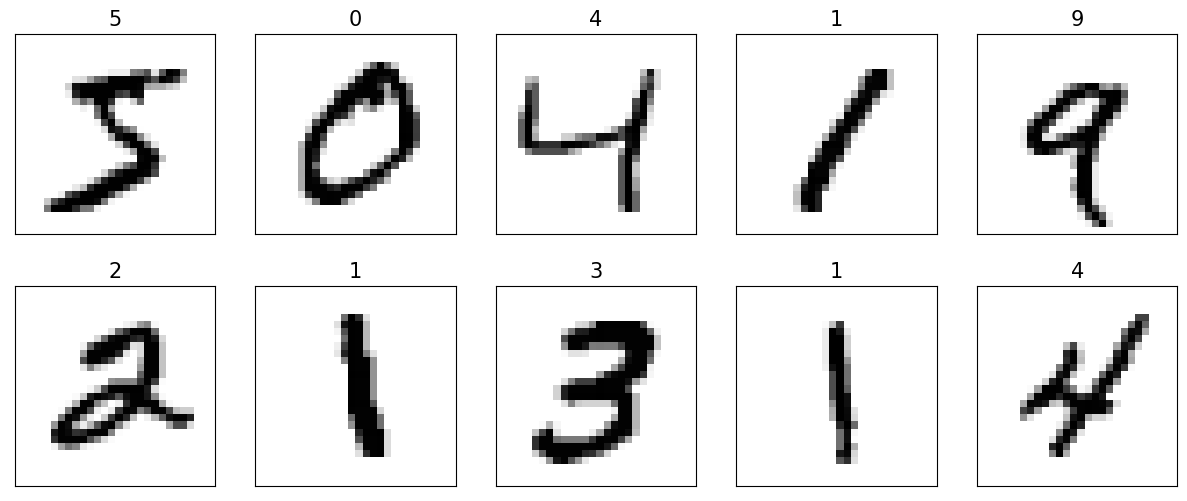

In [26]:
image_path = '../data/'
mnist_dataset = torchvision.datasets.MNIST(image_path, download=False)

assert isinstance(mnist_dataset, torch.utils.data.Dataset)

example = next(iter(mnist_dataset))
print(example)

fig = plt.figure(figsize=(15, 6))

for i, (image, label) in islice(enumerate(mnist_dataset), 10):
    ax = fig.add_subplot(2, 5, i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(image, cmap='gray_r')
    ax.set_title(f'{label}', size=15)

# Building a NN model in PyTorch

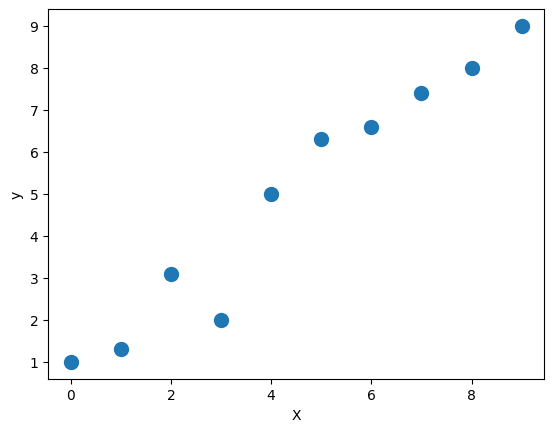

In [27]:
X_train = np.arange(10, dtype='float32').reshape((10, 1))
y_train = np.array([1.0, 1.3, 3.1, 2.0, 5.0, 6.3, 6.6, 7.4, 8.0, 9.0], dtype='float32')

plt.plot(X_train, y_train, 'o', markersize=10)
plt.xlabel("X")
plt.ylabel("y")
plt.show()

In [28]:
X_train_norm = (X_train - np.mean(X_train)) / np.std(X_train) # Normalize with Z score
X_train_norm = torch.from_numpy(X_train_norm)

y_train = torch.from_numpy(y_train).float()

train_ds = TensorDataset(X_train_norm, y_train)
batch_size = 1

train_dl = DataLoader(train_ds, batch_size, shuffle=True)

### Linear Regression Model from Scratch

In [29]:
torch.manual_seed(1)

weight = torch.randn(1)
weight.requires_grad_()

bias = torch.zeros(1, requires_grad=True)

def model(xb):
    return xb @ weight + bias

def loss_fn(input, target):
    return (input - target).pow(2).mean()

learning_rate = .001
num_epochs = 200
log_epochs = 10

for epoch in range(num_epochs):
    
    for x_batch, y_batch in train_dl:
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch.long())
        loss.backward()
        
    with torch.no_grad():
        weight -= weight.grad * learning_rate
        bias   -= bias.grad * learning_rate
        weight.grad.zero_()
        bias.grad.zero_()
        
    if epoch % log_epochs == 0:
        print(f'Epoch {epoch} Loss {loss.item() : .4f}')

Epoch 0 Loss  41.2725
Epoch 10 Loss  24.4285
Epoch 20 Loss  1.0575
Epoch 30 Loss  15.1630
Epoch 40 Loss  12.5989
Epoch 50 Loss  5.0840
Epoch 60 Loss  0.7865
Epoch 70 Loss  3.7489
Epoch 80 Loss  2.4036
Epoch 90 Loss  0.4430
Epoch 100 Loss  1.1155
Epoch 110 Loss  1.3195
Epoch 120 Loss  0.1064
Epoch 130 Loss  0.5676
Epoch 140 Loss  0.2216
Epoch 150 Loss  1.4862
Epoch 160 Loss  0.0483
Epoch 170 Loss  0.0061
Epoch 180 Loss  0.0016
Epoch 190 Loss  0.0294


Final Parameters: 2.645277738571167 4.715577602386475


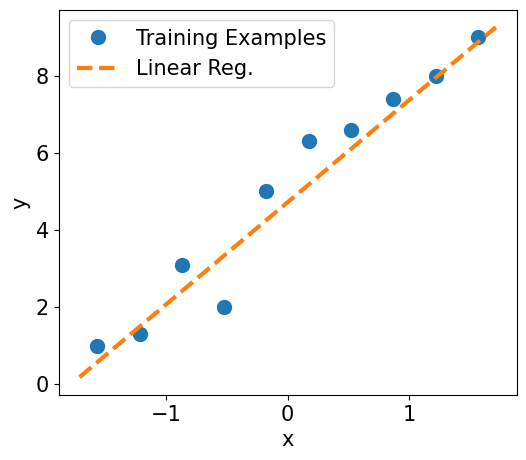

In [30]:
print(f'Final Parameters: {weight.item()} {bias.item()}')

X_test = np.linspace(0, 9, num=100, dtype='float32').reshape(-1, 1)
X_test_norm = (X_test - np.mean(X_test)) / np.std(X_test)
X_test_norm = torch.from_numpy(X_test_norm)
y_pred = model(X_test_norm).detach().numpy()

fig = plt.figure(figsize=(13, 5))
ax = fig.add_subplot(1, 2, 1)

plt.plot(X_train_norm, y_train, 'o', markersize=10)
plt.plot(X_test_norm, y_pred, '--', lw=3)
plt.legend(['Training Examples', 'Linear Reg.'], fontsize=15)
ax.set_xlabel('x', size=15)
ax.set_ylabel('y', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.show()

### Model Training via the torch.nn and torch.optim modules

In [31]:
import torch.nn as nn

input_size = 1
output_size = 1

loss_fn = nn.MSELoss(reduction='mean')
model = nn.Linear(input_size, output_size)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
        
        # Generate predictions
        pred = model(x_batch)[:, 0]
        
        # Calculate loss
        loss = loss_fn(pred, y_batch)
        
        # Compute Gradients
        loss.backward()
        
        # Update params using gradients
        optimizer.step()
        
        # Reset gradients to zero
        optimizer.zero_grad()
        
    if epoch % log_epochs == 0:
        print(f'Epoch {epoch} Loss {loss.item():.4f}')
        
print(f'Final Parameters: {model.weight.item()} {model.bias.item()}')

Epoch 0 Loss 24.6684
Epoch 10 Loss 29.1377
Epoch 20 Loss 20.9207
Epoch 30 Loss 0.1257
Epoch 40 Loss 12.4922
Epoch 50 Loss 1.7845
Epoch 60 Loss 7.6425
Epoch 70 Loss 2.5606
Epoch 80 Loss 0.0157
Epoch 90 Loss 0.7548
Epoch 100 Loss 0.8412
Epoch 110 Loss 0.4923
Epoch 120 Loss 0.0823
Epoch 130 Loss 0.0794
Epoch 140 Loss 0.0891
Epoch 150 Loss 0.0973
Epoch 160 Loss 0.1043
Epoch 170 Loss 0.1103
Epoch 180 Loss 0.0009
Epoch 190 Loss 0.0764
Final Parameters: 2.6496422290802 4.87706995010376


### Building a multilayer Perceptron for classifying flowers in the Iris dataset

In [32]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()
X = iris['data']
y = iris['target']
 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1./3, random_state=1
)

X_train_norm = (X_train - np.mean(X_train)) / np.std(X_train)
X_train_norm = torch.from_numpy(X_train_norm).float()
y_train = torch.from_numpy(y_train) 

train_ds = TensorDataset(X_train_norm, y_train)

torch.manual_seed(1)
batch_size = 2
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [33]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)  
        self.layer2 = nn.Linear(hidden_size, output_size)  

    def forward(self, x):
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        x = nn.Softmax(dim=1)(x)
        return x
    
input_size = X_train_norm.shape[1]
hidden_size = 16
output_size = 3
 
model = Model(input_size, hidden_size, output_size)

learning_rate = 0.001

loss_fn = nn.CrossEntropyLoss()
 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [34]:
num_epochs = 100
loss_hist = [0] * num_epochs
accuracy_hist = [0] * num_epochs

for epoch in range(num_epochs):

    for x_batch, y_batch in train_dl:
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch.long())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
        loss_hist[epoch] += loss.item()*y_batch.size(0)
        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        accuracy_hist[epoch] += is_correct.sum()
        
    loss_hist[epoch] /= len(train_dl.dataset)
    accuracy_hist[epoch] /= len(train_dl.dataset)

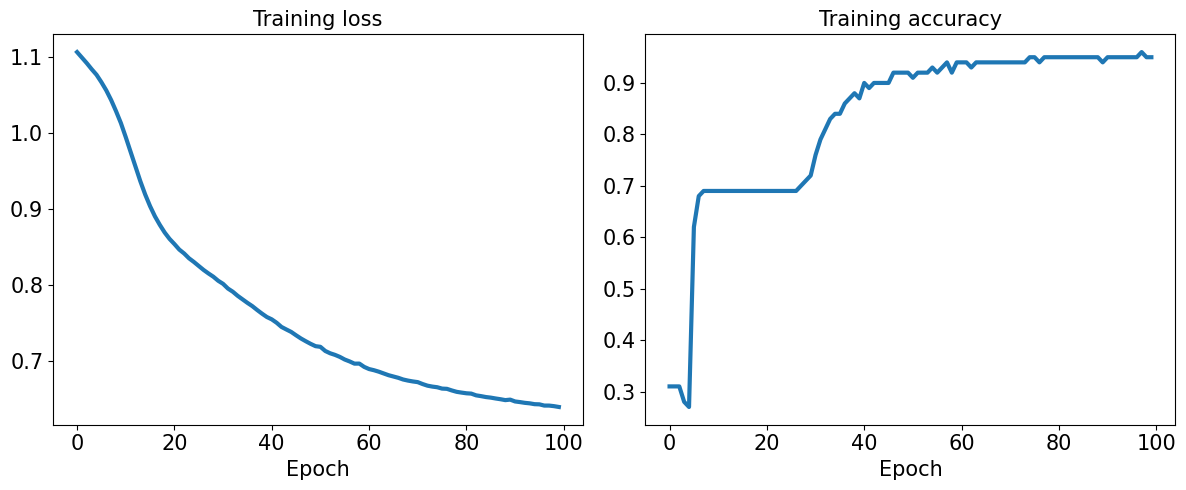

In [35]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(loss_hist, lw=3)
ax.set_title('Training loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(accuracy_hist, lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()

plt.show()

In [36]:
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)
X_test_norm = torch.from_numpy(X_test_norm).float()
y_test = torch.from_numpy(y_test) 
pred_test = model(X_test_norm)

correct = (torch.argmax(pred_test, dim=1) == y_test).float()
accuracy = correct.mean()
 
print(f'Test Acc.: {accuracy:.4f}')

Test Acc.: 0.9800


### Saving and reloading a trained model

In [37]:
pretrained_dir = Path('../data/pretrained/')
pretrained_dir.mkdir(exist_ok=True)

full_cls_path = pretrained_dir / 'iris_classifier.pt'
cls_state_path = pretrained_dir / 'iris_classifier_state.pt'

torch.save(model, full_cls_path)
torch.save(model.state_dict(), cls_state_path)

In [38]:
model_new_full = torch.load(full_cls_path)

model_new_state = Model(input_size, hidden_size, output_size)
model_new_state.load_state_dict(torch.load(cls_state_path))

model_new_full.eval()
model_new_state.eval()

pred_test = model_new_full(X_test_norm)
correct = (torch.argmax(pred_test, dim=1) == y_test).float()
accuracy = correct.mean()
print(f'Test Acc: {accuracy : .4f}')

pred_test = model_new_state(X_test_norm)
correct = (torch.argmax(pred_test, dim=1) == y_test).float()
accuracy = correct.mean()
print(f'Test Acc: {accuracy : .4f}')

Test Acc:  0.9800
Test Acc:  0.9800


## Choosing Activation Functions for a Multi-layer Neural Network

### Logistic Function Recap

In [39]:
X = np.array([1, 1.4, 2.5])
w = np.array([0.4, 0.3, 0.5])

def net_input(X, w):
    return np.dot(X, w)

def logistic(z):
    return 1.0 / (1.0 + np.exp(-z))

def logistic_activation(X, w):
    z = net_input(X, w)
    return logistic(z)

print(f'P(y=1|x) = {logistic_activation(X, w) : .3f}')

P(y=1|x) =  0.888


In [42]:
'''
    An output layer consisting of multiple Logistic Activation functions does not produce meaningful
    results, as demonstrated here.
    
    This is due to the fact that our output units (probabilities of class membership for each label)
    do not sum to 1. This is not an issue when we want to predict only class labels, but it is an issue
    for predicting probabilities.
    
'''
# W : array with shape = (n_output_units, n_hidden_units+1)
# note that the first column are the bias units

W = np.array([[1.1, 1.2, 0.8, 0.4],
              [0.2, 0.4, 1.0, 0.2],
              [0.6, 1.5, 1.2, 0.7]])

# A : data array with shape = (n_hidden_units + 1, n_samples)
# note that the first column of this array must be 1

A = np.array([[1, 0.1, 0.4, 0.6]])
Z = np.dot(W, A[0])
y_probas = logistic(Z)
y_class = np.argmax(Z, axis=0)

print('Net Input: \n', Z)
print('Output Units:\n', y_probas) 
print(f'Predicted Class label: {y_class}')

Net Input: 
 [1.78 0.76 1.65]
Output Units:
 [0.856 0.681 0.839]
Predicted Class label: 0


### Estimating Probas using SoftMax

In [45]:
''' Softmax is a better option as our probas sum to 1 '''
def softmax(z):
    return np.exp(z) / np.sum(np.exp(z))

y_probas = softmax(Z)
print(f'Probabilities:\n{y_probas}')
print(np.sum(y_probas))

Probabilities:
[0.447 0.161 0.392]
1.0


In [46]:
torch.softmax(torch.from_numpy(Z), dim=0)

tensor([0.4467, 0.1611, 0.3922], dtype=torch.float64)

### Broadening the output spectrum using a Hyperbolic Tangent (tanh)

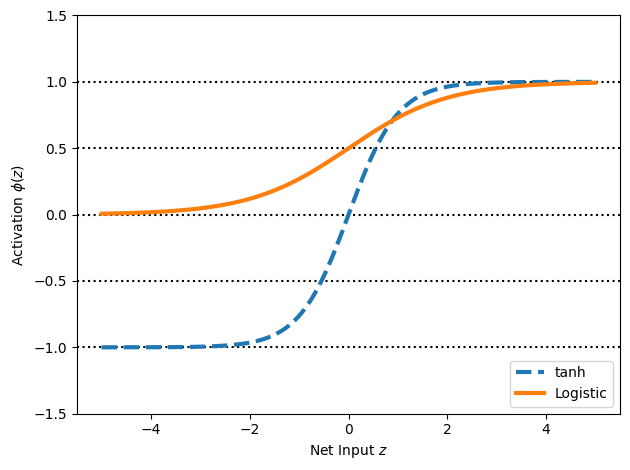

In [52]:
def tanh(z):
    e_p = np.exp(z)
    e_m = np.exp(-z)
    return (e_p - e_m) / (e_p + e_m)

z = np.arange(-5, 5, .005)
log_act = logistic(z)
tanh_act = tanh(z)

plt.ylim([-1.5, 1.5])

plt.xlabel("Net Input $z$")
plt.ylabel("Activation $\phi(z)$")

plt.axhline(1, color='black', linestyle=':')
plt.axhline(.5, color='black', linestyle=':')
plt.axhline(0, color='black', linestyle=':')
plt.axhline(-.5, color='black', linestyle=':')
plt.axhline(-1, color='black', linestyle=':')

plt.plot(z, tanh_act, linewidth=3, linestyle='--', label='tanh')
plt.plot(z, log_act, linewidth=3, label='Logistic')

plt.legend(loc='lower right')
plt.tight_layout()
plt.show()